In [1]:

import re, numpy as np, string, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from nltk.corpus import stopwords
from collections import Counter
from PIL import Image
from nltk.stem.wordnet import WordNetLemmatizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette


import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel


from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [99]:
df = pd.read_csv('CSV_Final_negative_la.csv')

## NLTK Stop words

In [3]:

stop_words = stopwords.words('english')

#stop_words.extend([])

In [4]:
type(stop_words)

list

## Vectorizing & Document Matrix

In [5]:
vectorizer = CountVectorizer(stop_words='english')

docs = vectorizer.fit_transform(df.comments)

features = vectorizer.get_feature_names()


In [6]:

tf = TfidfVectorizer(stop_words=stopwords, min_df = 2, max_df=0.7)

docs = tf.fit_transform(df['comments'])

features = tf.get_feature_names()



"\ntf = TfidfVectorizer(stop_words=stopwords, min_df = 2, max_df=0.7)\n\ndocs = tf.fit_transform(df['comments'])\n\nfeatures = tf.get_feature_names()\n\n"

## Read samples of reviews

In [7]:
for sample in df['spacy_doc'].sample(5).values:
    print(sample)
    print()

Hosts have terrible communication skills. Had to wait for host to arrive just to check in. I DO NOT recommend these hosts and this place.

The place is cozy with a clean kitchen to cook. Genghis is a hospitable person. The room on the provided photo looks bigger, but in general it is OK. Wifi was bad, but I am sure it will be solved soon.

Nickie's place is simple, quiet and close to freeways. Thats all we needed.

This space is amazingly close to Universal.  It's about a $5.00 Uber ride away, or if you want to walk it - you could do that in under half an hour.  If you are going to be at Universal for the day, this is the spot for you. 

It wasn’t what I excepted at all. The photos will make the house look better but when you get there it’s not the same. Filters!!! Yes, the parking is horrible. If you’re coming from out of town and not familiar with Long Beach area then you’ll be disappointed.



In [8]:
for sample in df['comments'].sample(5).values:
    print(sample)
    print()

Place is worderfull and very private.

The only problem with staying here is that you will not want to leave.....

Everything is amzing！nice！romantic！gorgeous！

The host canceled this reservation 13 days before arrival. This is an automated posting.

Great location.  Wifi and check in were good, and the host was polite and responsive. But overall a meh Airbnb, certainly much worse than other “Plus” places I’ve stayed and doesn’t deserve to be in that category. It’s your typical run-as-a-business airbnb. Decor and light look much worse in person, couch is uncomfortable, doesn’t feel like a home at all. The outdoor area was dirty and much less pleasant than it looks in the pictures. For a weeklong stay I was given a single towel that was damp when I arrived. The shower pours water out into the bathroom and hallway and there’s no bath mat. Parking space was very tight and you can be blocked in by the guests in the front unit. Many bugs in the home. Had a mobile AC unit which was insuffici

## Most Used Words

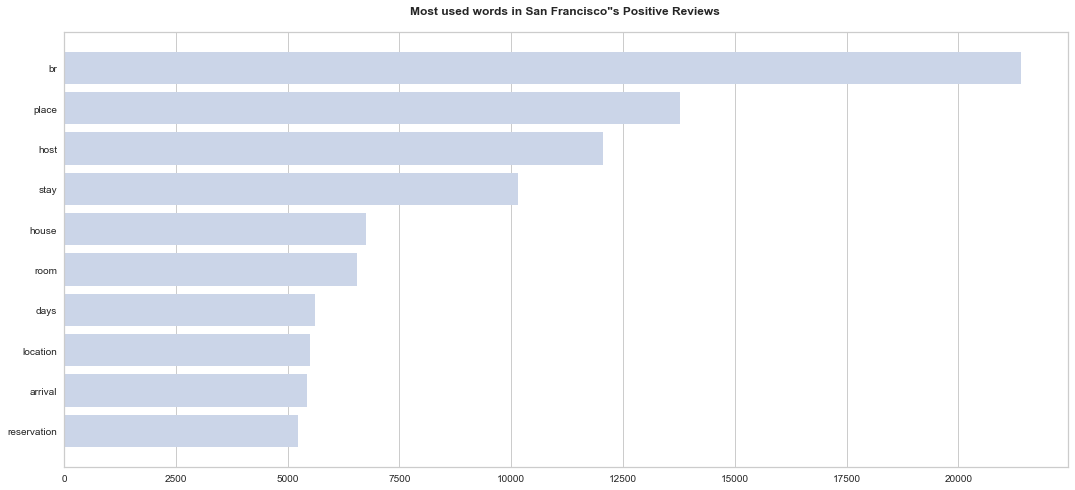

In [9]:
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('Most used words in Los Angeles Negative Reviews \n', fontweight='bold')

##yellowbrick
vis = FreqDistVisualizer(features=features, n = 10)
vis.fit(docs)
vis.poof;

## Creating World Cloud words

In [97]:
def wordcloud_words(wordcloud):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(' Los Angeles Negative Reviews\n', fontsize=18, fontweight='bold')
    plt.savefig('LAnEgative')
    plt.show()

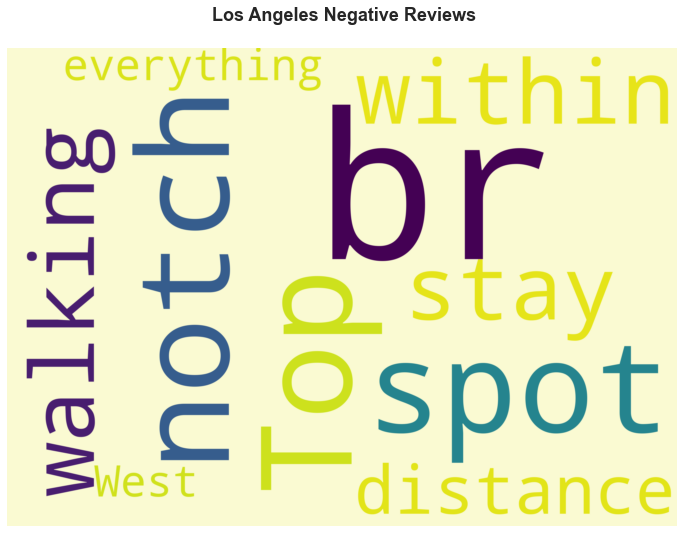

In [98]:
posWords = WordCloud(max_font_size=None, max_words = 10, background_color="lightgoldenrodyellow", 
                      width=3500, height=2500,
                      stopwords=stopwords.words('english')).generate(str(df.comments.values))

wordcloud_words(posWords)

## Simple Additional Cleaning

In [12]:
def clean(sents):
    for word in sents:
        word = re.sub('\s+', ' ', word)  
        word = re.sub("\'", "", word)  
        word = gensim.utils.simple_preprocess(str(word), deacc=True) 
        yield(word)  


# Apply cleaning

In [13]:
all_data = df.comments.values.tolist()
clean_sent = list(clean(all_data))
print(clean_sent[:1])

[['top', 'notch', 'spot', 'to', 'stay', 'within', 'walking', 'distance', 'to', 'most', 'everything', 'in', 'west', 'hollywood']]


In [14]:
print(clean_sent[:5])

[['top', 'notch', 'spot', 'to', 'stay', 'within', 'walking', 'distance', 'to', 'most', 'everything', 'in', 'west', 'hollywood'], ['very', 'unreliable', 'host', 'br', 'br', 'wasnt', 'helpful', 'found', 'mold', 'in', 'the', 'bathroom', 'and', 'the', 'owner', 'blamed', 'it', 'on', 'me', 'when', 'it', 'is', 'lack', 'of', 'upkeep', 'of', 'his', 'property', 'very', 'rude', 'and', 'lazy', 'br', 'br', 'would', 'not', 'recommended', 'staying', 'here'], ['unit', 'was', 'hot', 'ac', 'wasnt', 'great'], ['the', 'host', 'canceled', 'this', 'reservation', 'days', 'before', 'arrival', 'this', 'is', 'an', 'automated', 'posting'], ['wonderfull', 'place', 'to', 'stay', 'in', 'la', 'near', 'venice', 'beach']]


## Bigram & Trigram

In [15]:

bi_gram = gensim.models.Phrases(clean_sent, min_count=5, threshold=100) 

tri_gram = gensim.models.Phrases(bi_gram[clean_sent], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bi_gram)

trigram_mod = gensim.models.phrases.Phraser(tri_gram)

## Clean, Remove & Lemma

In [16]:

def cleaning(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
       
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    
    nlp = spacy.load("en_core_web_sm")
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])     
    
    clean_text = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    
    return clean_text


## Apply final cleaning on prev cleaned list

In [17]:
doc_clean = cleaning(clean_sent)
doc_clean[:5]

[['top_notch', 'spot', 'stay'],
 ['unreliable',
  'br',
  'helpful',
  'find',
  'mold',
  'bathroom',
  'owner',
  'blame',
  'upkeep',
  'property',
  'rude',
  'lazy',
  'br',
  'recommend',
  'stay'],
 ['unit', 'hot', 'great'],
 ['cancel', 'reservation', 'day', 'arrival', 'automate', 'posting'],
 ['wonderfull', 'place', 'stay', 'beach']]

## Create Dictionary & Corpus

In [18]:
doc_dict = corpora.Dictionary(doc_clean)

corpus = [doc_dict.doc2bow(text) for text in doc_clean]


## Build The LDA model

In [19]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=doc_dict,num_topics=8, random_state=33,
                                           update_every=1,chunksize=15,passes=10,alpha='symmetric',iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.036*"stay" + 0.032*"apartment" + 0.030*"bad" + 0.024*"tell" + '
  '0.023*"experience" + 0.022*"never" + 0.021*"back" + 0.021*"thing" + '
  '0.021*"give" + 0.021*"address"'),
 (1,
  '0.132*"place" + 0.085*"stay" + 0.057*"bed" + 0.032*"look" + 0.032*"house" + '
  '0.029*"picture" + 0.022*"sleep" + 0.019*"walk" + 0.018*"little" + '
  '0.018*"expect"'),
 (2,
  '0.144*"br" + 0.077*"parking" + 0.063*"bathroom" + 0.047*"find" + '
  '0.044*"list" + 0.033*"street" + 0.030*"property" + 0.025*"owner" + '
  '0.019*"spot" + 0.016*"garage"'),
 (3,
  '0.349*"day" + 0.092*"neighborhood" + 0.087*"cancel" + 0.081*"quiet" + '
  '0.074*"bring" + 0.065*"reservation" + 0.057*"arrival" + 0.033*"middle" + '
  '0.018*"life" + 0.004*"cafe"'),
 (4,
  '0.034*"ask" + 0.030*"pay" + 0.028*"arrive" + 0.025*"home" + 0.025*"refund" '
  '+ 0.024*"book" + 0.021*"issue" + 0.017*"pm" + 0.015*"contact" + '
  '0.015*"respond"'),
 (5,
  '0.114*"check" + 0.101*"night" + 0.087*"airbnb" + 0.049*"kitchen" + '
  '0.042*"

## List of words by topic

In [20]:
topics = lda_model.show_topics(formatted=False)

In [21]:
type(topics)

list

In [22]:
topics

[(0,
  [('stay', 0.036281563),
   ('apartment', 0.031538174),
   ('bad', 0.02992971),
   ('tell', 0.023676509),
   ('experience', 0.022632733),
   ('never', 0.022044417),
   ('back', 0.020852908),
   ('thing', 0.020639908),
   ('give', 0.020585977),
   ('address', 0.020572186)]),
 (1,
  [('place', 0.13235106),
   ('stay', 0.08546022),
   ('bed', 0.05706462),
   ('look', 0.03248654),
   ('house', 0.032417964),
   ('picture', 0.02908464),
   ('sleep', 0.02170058),
   ('walk', 0.01910314),
   ('little', 0.017645454),
   ('expect', 0.017568227)]),
 (2,
  [('br', 0.14376095),
   ('parking', 0.07733869),
   ('bathroom', 0.06327953),
   ('find', 0.04713027),
   ('list', 0.044165984),
   ('street', 0.03342609),
   ('property', 0.030238952),
   ('owner', 0.025284806),
   ('spot', 0.018901987),
   ('garage', 0.015814444)]),
 (3,
  [('day', 0.3486399),
   ('neighborhood', 0.09210689),
   ('cancel', 0.08667321),
   ('quiet', 0.081041455),
   ('bring', 0.07431284),
   ('reservation', 0.06507353),
 

## Visualize the words By Topic

In [23]:
topics = lda_model.show_topics(formatted=False)

In [24]:
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

In [25]:
words_tops = []

for i, topic in topics:
    for word, weight in topic:
        words_tops.append([word, i , weight, counter[word]])
        

df_f = pd.DataFrame(words_tops, columns=['word', 'topic_n', 'most_appear', 'word_count']) 

In [26]:
df_f.sort_values('most_appear', ascending=False).head(12)

,word,topic_n,most_appear,word_count
30,day,3,0.348640,9153
20,br,2,0.143761,8820
10,place,1,0.132351,13685
50,check,5,0.113743,4250
51,night,5,0.100524,5324
31,neighborhood,3,0.092107,1412
52,airbnb,5,0.087302,3443
32,cancel,3,0.086673,5422
11,stay,1,0.085460,13128
33,quiet,3,0.081041,1613


## Word Count as Weights by Topic Visualization

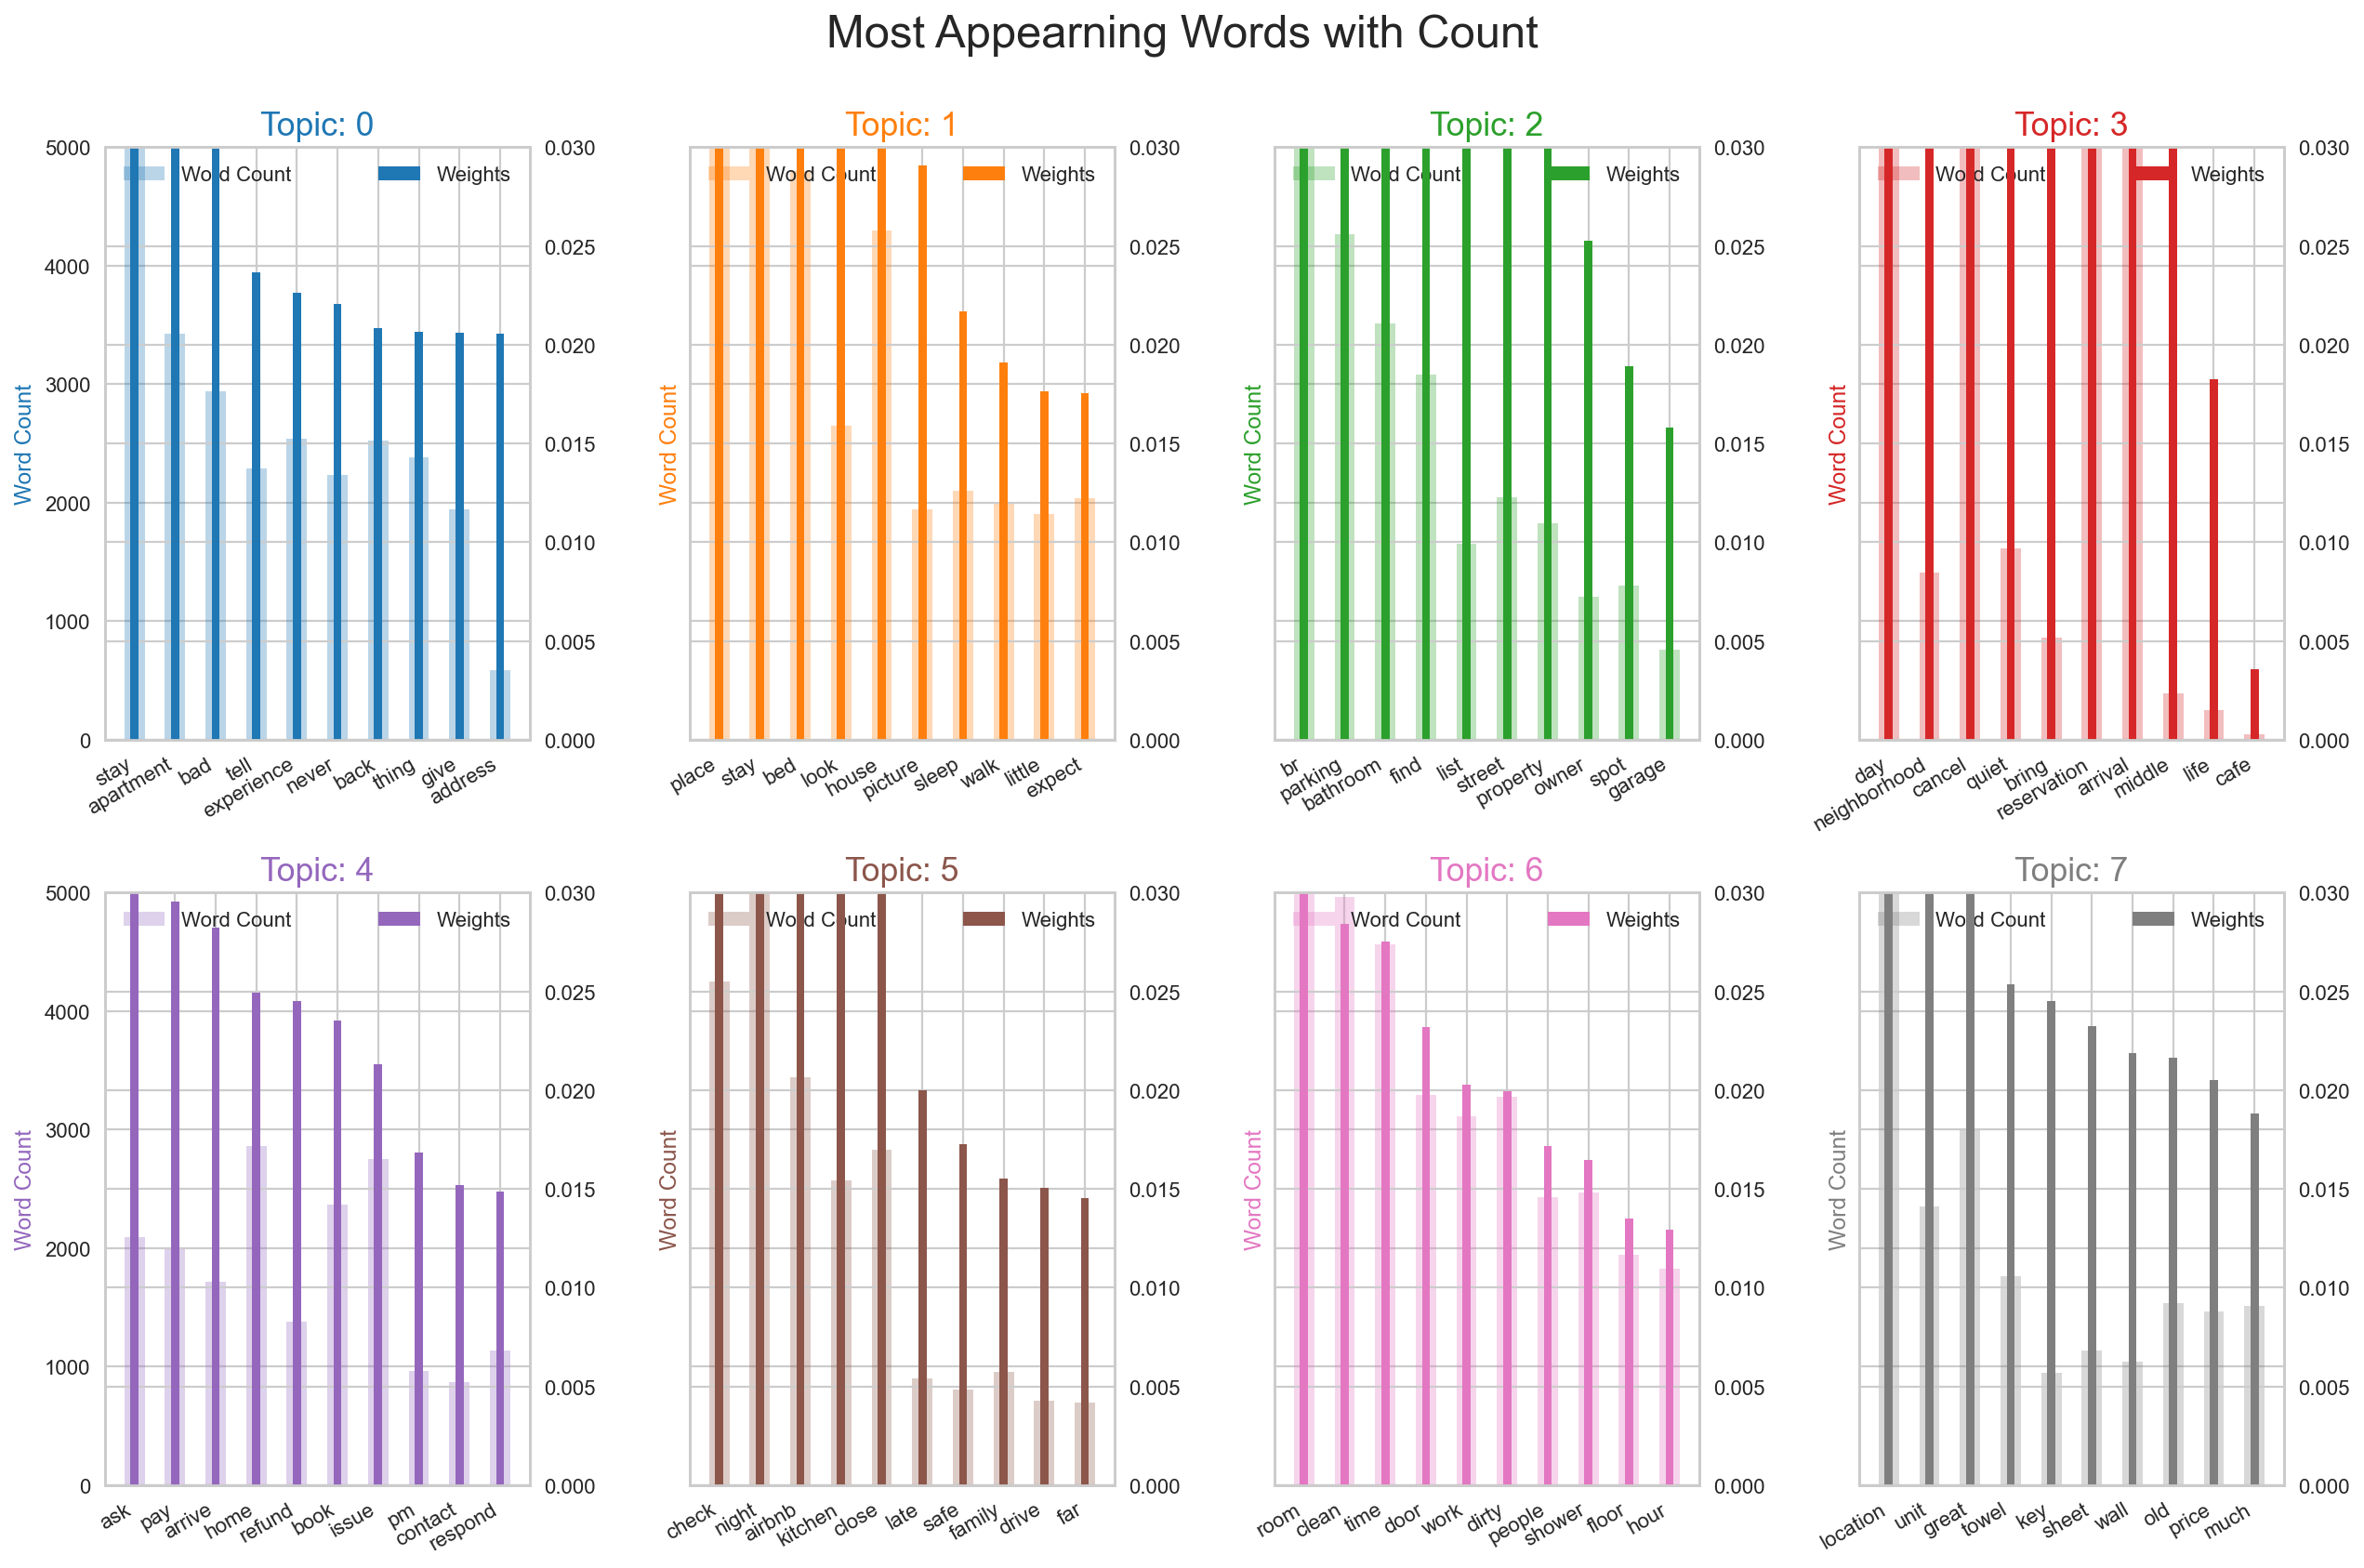

In [27]:
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    
    ax_twin.bar(x='word', height="most_appear", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    
    ax.set_xticklabels(df_f.loc[df_f.topic_n==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Most Appearning Words with Count', fontsize=22, y=1.05)   

plt.show()

## Words by Topic WordCloud

In [28]:

colors2 = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

topic_clouds = WordCloud(stopwords=stop_words,background_color='white', width=2500,height=1800, max_words=25, colormap='tab10',
                  color_func=lambda *args, **kwargs: colors2[i],prefer_horizontal=1.0)


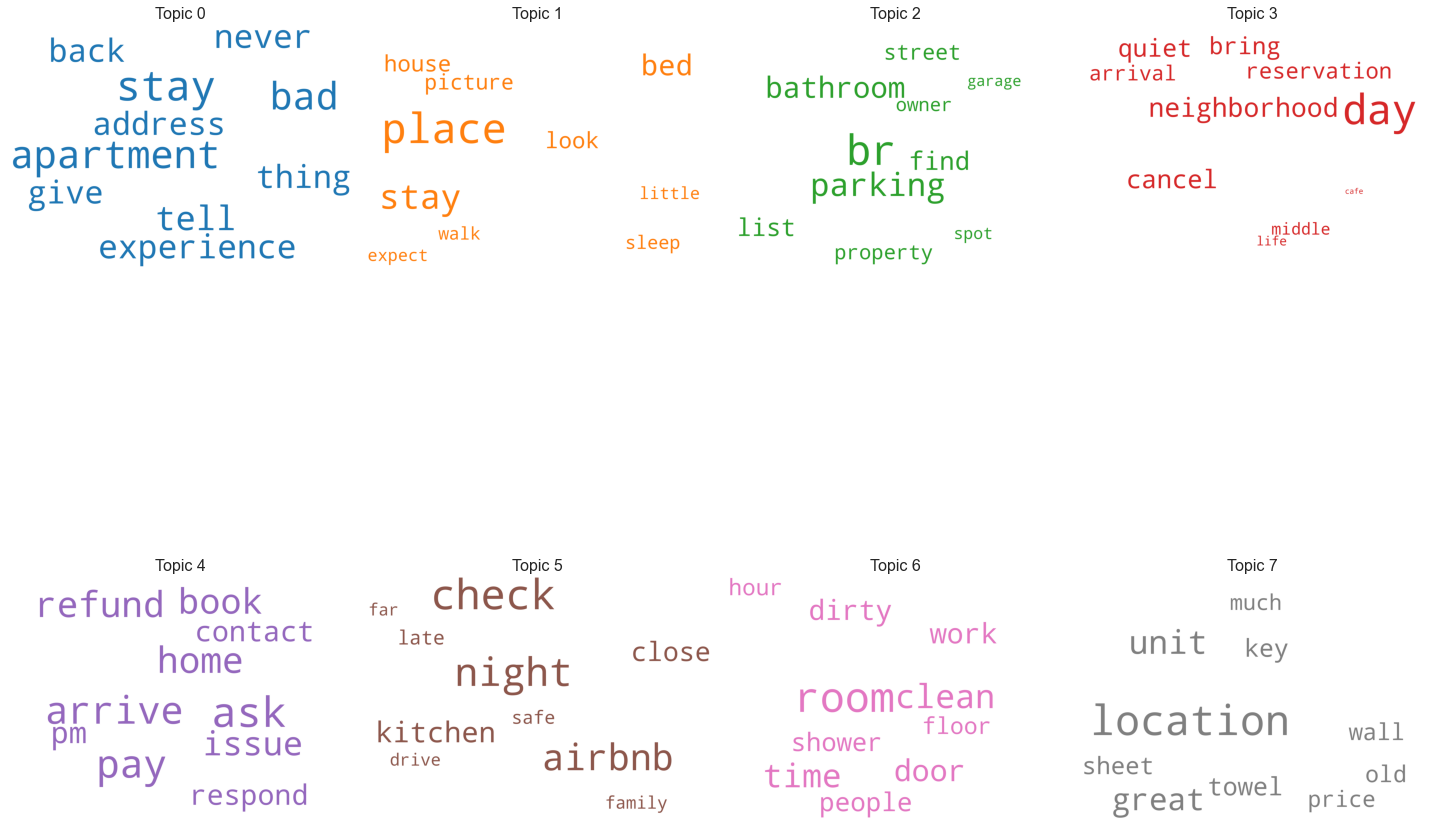

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(20,20), sharex=True, sharey=True)
 

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    
    topic_words = dict(topics[i][1])
    topic_clouds.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(topic_clouds)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##  NMF run using 3 topics

In [30]:

nmf = NMF(n_components=3)

nmf.fit(docs)

NMF(n_components=3)

In [31]:
topic_matrix = nmf.transform(docs)

In [32]:
topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df['comments'] = df['comments']
topic_matrix_df.head()

,topic_0,topic_1,topic_2,comments
0,0.000000,0.020679,0.000000,Top notch spot to stay within walking distance...
1,0.179078,0.003029,0.032410,"very unreliable host, <br/><br/>Wasn't helpfu..."
2,0.000390,0.015032,0.000000,Unit was hot. AC wasn't great.
3,0.000000,0.000000,0.197893,The host canceled this reservation 88 days bef...
4,0.000000,0.044878,0.000000,Wonderfull place to stay in LA near Venice Bea...


In [33]:
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=features).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2
00,0.015963,0.106246,0.007352
000,0.005496,0.024618,0.005948
0000am,0.000000,0.000199,0.000000
001,0.000000,0.000431,0.000000
00am,0.000000,0.008986,0.002017


## Read Samples from Topic 0 

In [34]:
for review in topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['comments'].values:
    print(review)
    print()

Please be aware!!<br/>Avoid Avoid Avoid this place <br/><br/>I want to share it with anyone who rents from this listing!!!<br/><br/>Warning:<br/>Avoid Avoid Avoid this place at any price  again & again <br/><br/>This place is a 1-Star level like motel almost as if it houses prostitutes, drug dealers , or some other  shady Adult Enterprises it  might run  as a Home Business.<br/><br/>Location:<br/>Is Horrific location is in unsafe & ugly area of Hacienda Heights.<br/><br/>Most are very poor & beaten up housing area with its  suddenly appearing out of the  blue a set of the neighborhood street filled  with a few larger sized homes- of a working, lower middle class level.<br/>And then that neighborhood suddenly ends right there too.<br/><br/>That was also odd due to all surrounding area that was so shady & poor looking .<br/><br/>Freeways nearby:<br/>Crazy & so many angry drivers on along this specific direction.<br/>Not sure why  but something was so distinctive about it.<br/>It’s  also 

## Read Samples from Topic 1 


In [35]:
for review in topic_matrix_df.sort_values(by='topic_1', ascending=False).head(5)['comments'].values:
    print(review)
    print()

I don’t use to writing a review about my stay,even at the hotel services but in this case i need to tell the truth about my stay, <br/>Before i make a my review, i need to say that every guest who stay at Russell’s place may or may not having a good stay,but in my case i was definitely having a really bad and uncomfortable stay/sleep<br/>1st of all, <br/>The bathroom shower was a kind of small bathtub with a small curtain with no glassdoor, and everytime when you took a shower even with the curtain inside of the bathtub,after the shower there will be always a water spilled on the bathroom floor, and the worst part is, the host said there’s a water dripping into the dining room downstair(1st floor), and his blaming me as guest just because i took a shower in a shower bathroom which is really non-sense, how could me as guest know anything about his place? how could i know when is the last time he did the general check-up? how could i know when is the last time he did the general cleaning

## Read Samples from Topic 2


In [36]:
for review in topic_matrix_df.sort_values(by='topic_2', ascending=False).head(5)['comments'].values:
    print(review)
    print()

First, I would like to say this host is money greedy. Second, I would like to say I would not recommend this reservation to anyone except for the location. Before the trip even started I wish I was able to cancel my reservation with this host. To start, when I first booked the reservation. I booked a reservation for 7 guest The next day a family member of mine wanted to tag along and join the trip. So, I informed the host that I was trying to make a change to the reservation and add a extra guest. She immediately replied and sent me a confirmation link to accept the reservation change. Now the reservation is set to 8 guest and Of course adding an extra guest was going make the reservation go up some more money. About 200$. No longer then 24 hours go past. I messaged her again asking to change the reservation back to 7 guest because of some personal problem an guest had come up.  Not only did the host take a few hours to reply about change the reservation back. But when the host replied

# Top 10 Words from Each Topic

In [37]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [38]:
display_topics(nmf, features, 10)


Topic  0
br, airbnb, host, house, room, stay, kitchen, did, unit, time

Topic  1
place, stay, house, room, host, airbnb, did, night, just, didn

Topic  2
host, reservation, arrival, canceled, automated, posting, days, day, airbnb, refund


In [39]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2
br,22.271373,0.000000,0.000000
airbnb,0.812643,2.966115,0.341809
host,0.740156,3.075264,6.777320
house,0.533361,3.726110,0.000000
room,0.522577,3.498247,0.000000
stay,0.413808,4.888724,0.000000
kitchen,0.413286,1.352239,0.000000
did,0.399296,2.649556,0.099131
unit,0.393091,1.095055,0.068534
time,0.391549,2.120309,0.043100


In [40]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2
place,0.000000,6.416054,0.000000
stay,0.413808,4.888724,0.000000
house,0.533361,3.726110,0.000000
room,0.522577,3.498247,0.000000
host,0.740156,3.075264,6.777320
airbnb,0.812643,2.966115,0.341809
did,0.399296,2.649556,0.099131
night,0.322067,2.601715,0.000000
just,0.224330,2.586637,0.000000
didn,0.247948,2.294661,0.000000


In [41]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2
host,0.740156,3.075264,6.777320
reservation,0.000000,0.000000,4.799875
arrival,0.000000,0.000000,4.719189
canceled,0.000000,0.000000,4.575510
automated,0.000000,0.000000,4.519209
posting,0.000000,0.000000,4.515438
days,0.108236,0.274317,4.455529
day,0.320958,1.965167,0.551212
airbnb,0.812643,2.966115,0.341809
refund,0.098635,0.892666,0.178307


In [42]:
def top_reviews(topic_matrix_df, topic, num_of_reviews):
    return (topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(num_of_reviews)['comments']
            .values)

def top_words(word_topic_matrix_df, topic, n_of_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_of_words))[topic]

In [43]:
for review in top_reviews(topic_matrix_df, 'topic_0', 5):
    print(review)
    print()

Please be aware!!<br/>Avoid Avoid Avoid this place <br/><br/>I want to share it with anyone who rents from this listing!!!<br/><br/>Warning:<br/>Avoid Avoid Avoid this place at any price  again & again <br/><br/>This place is a 1-Star level like motel almost as if it houses prostitutes, drug dealers , or some other  shady Adult Enterprises it  might run  as a Home Business.<br/><br/>Location:<br/>Is Horrific location is in unsafe & ugly area of Hacienda Heights.<br/><br/>Most are very poor & beaten up housing area with its  suddenly appearing out of the  blue a set of the neighborhood street filled  with a few larger sized homes- of a working, lower middle class level.<br/>And then that neighborhood suddenly ends right there too.<br/><br/>That was also odd due to all surrounding area that was so shady & poor looking .<br/><br/>Freeways nearby:<br/>Crazy & so many angry drivers on along this specific direction.<br/>Not sure why  but something was so distinctive about it.<br/>It’s  also 

In [44]:
top_words(word_topic_matrix_df, 'topic_0', 10)

br         22.271373
airbnb      0.812643
host        0.740156
house       0.533361
room        0.522577
stay        0.413808
kitchen     0.413286
did         0.399296
unit        0.393091
time        0.391549
Name: topic_0, dtype: float64

In [45]:
for review in top_reviews(topic_matrix_df, 'topic_1', 5):
    print(review)
    print()

I don’t use to writing a review about my stay,even at the hotel services but in this case i need to tell the truth about my stay, <br/>Before i make a my review, i need to say that every guest who stay at Russell’s place may or may not having a good stay,but in my case i was definitely having a really bad and uncomfortable stay/sleep<br/>1st of all, <br/>The bathroom shower was a kind of small bathtub with a small curtain with no glassdoor, and everytime when you took a shower even with the curtain inside of the bathtub,after the shower there will be always a water spilled on the bathroom floor, and the worst part is, the host said there’s a water dripping into the dining room downstair(1st floor), and his blaming me as guest just because i took a shower in a shower bathroom which is really non-sense, how could me as guest know anything about his place? how could i know when is the last time he did the general check-up? how could i know when is the last time he did the general cleaning

In [46]:
top_words(word_topic_matrix_df, 'topic_1', 10)

place     6.416054
stay      4.888724
house     3.726110
room      3.498247
host      3.075264
airbnb    2.966115
did       2.649556
night     2.601715
just      2.586637
didn      2.294661
Name: topic_1, dtype: float64

In [47]:
for review in top_reviews(topic_matrix_df, 'topic_2', 5):
    print(review)
    print()

First, I would like to say this host is money greedy. Second, I would like to say I would not recommend this reservation to anyone except for the location. Before the trip even started I wish I was able to cancel my reservation with this host. To start, when I first booked the reservation. I booked a reservation for 7 guest The next day a family member of mine wanted to tag along and join the trip. So, I informed the host that I was trying to make a change to the reservation and add a extra guest. She immediately replied and sent me a confirmation link to accept the reservation change. Now the reservation is set to 8 guest and Of course adding an extra guest was going make the reservation go up some more money. About 200$. No longer then 24 hours go past. I messaged her again asking to change the reservation back to 7 guest because of some personal problem an guest had come up.  Not only did the host take a few hours to reply about change the reservation back. But when the host replied

In [48]:
top_words(word_topic_matrix_df, 'topic_2', 10)

host           6.777320
reservation    4.799875
arrival        4.719189
canceled       4.575510
automated      4.519209
posting        4.515438
days           4.455529
day            0.551212
airbnb         0.341809
refund         0.178307
Name: topic_2, dtype: float64

In [49]:
t1 = top_words(word_topic_matrix_df, 'topic_0', 100)
t1_10 = top_words(word_topic_matrix_df, 'topic_0', 10)

In [50]:
tl_dict = t1.to_dict()

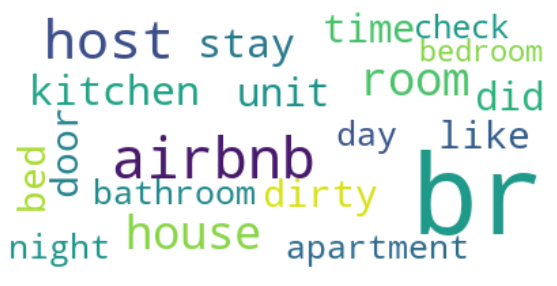

In [51]:
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(tl_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic1')
plt.show()


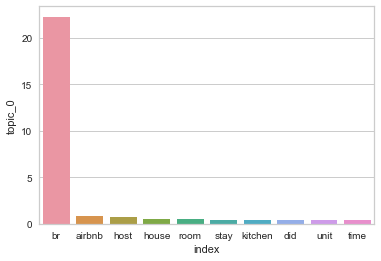

In [52]:
l_df = t1_10.to_frame()
l_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_0', data=l_df);

In [53]:
second_top = top_words(word_topic_matrix_df, 'topic_1', 100)
t2_10 = top_words(word_topic_matrix_df, 'topic_1', 10)

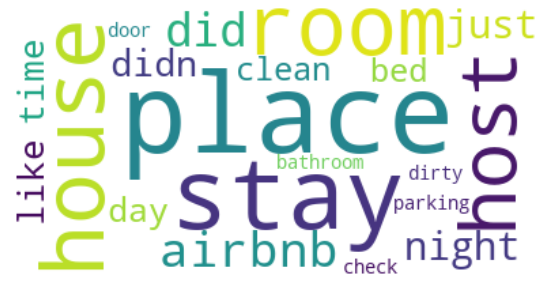

In [54]:
second_top_dict = second_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(second_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic2')
plt.show()


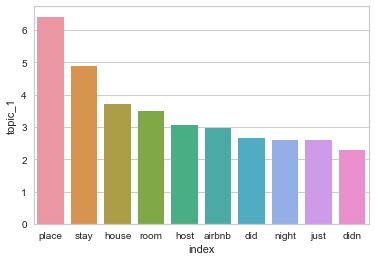

In [55]:
t2_df = t2_10.to_frame()
t2_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_1', data=t2_df);

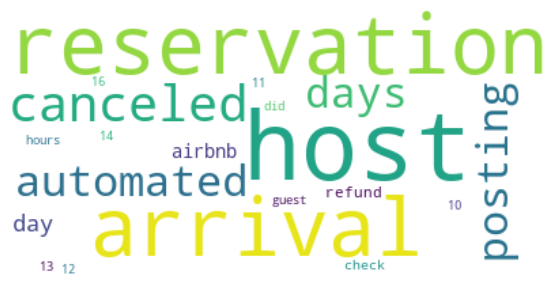

In [56]:
third_top = top_words(word_topic_matrix_df, 'topic_2', 100)
t3_10 = top_words(word_topic_matrix_df, 'topic_2', 10)


third_top_dict = third_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(third_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic3')
plt.show()

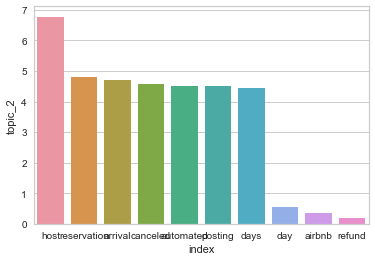

In [57]:
t3_df = t3_10.to_frame()
t3_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_2', data=t3_df);

## Build The LDA model With 5 Topics

In [58]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=doc_dict,num_topics=5, random_state=33,
                                           update_every=1,chunksize=15,passes=10,alpha='symmetric',iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.081*"br" + 0.069*"room" + 0.045*"location" + 0.033*"bad" + 0.025*"list" + '
  '0.025*"experience" + 0.023*"great" + 0.023*"back" + 0.023*"thing" + '
  '0.019*"first"'),
 (1,
  '0.271*"day" + 0.175*"house" + 0.131*"close" + 0.067*"cancel" + '
  '0.051*"reservation" + 0.044*"arrival" + 0.010*"breakfast" + 0.007*"adress" '
  '+ 0.005*"venice" + 0.003*"wonderful"'),
 (2,
  '0.111*"stay" + 0.108*"place" + 0.041*"airbnb" + 0.037*"bathroom" + '
  '0.028*"find" + 0.018*"property" + 0.017*"overall" + 0.016*"however" + '
  '0.015*"recommend" + 0.015*"owner"'),
 (3,
  '0.036*"check" + 0.030*"parking" + 0.024*"apartment" + 0.021*"night" + '
  '0.019*"guest" + 0.018*"unit" + 0.017*"people" + 0.015*"kitchen" + '
  '0.014*"issue" + 0.014*"door"'),
 (4,
  '0.020*"bed" + 0.015*"dirty" + 0.015*"leave" + 0.015*"clean" + 0.013*"book" '
  '+ 0.012*"tell" + 0.011*"feel" + 0.011*"never" + 0.011*"shower" + '
  '0.010*"address"')]


## List of words by topic

In [59]:
topics = lda_model.show_topics(formatted=False)

In [60]:
type(topics)

list

In [61]:
topics

[(0,
  [('br', 0.08067301),
   ('room', 0.06875053),
   ('location', 0.04493883),
   ('bad', 0.032631874),
   ('list', 0.024784325),
   ('experience', 0.024676036),
   ('great', 0.023054697),
   ('back', 0.022735566),
   ('thing', 0.02250353),
   ('first', 0.018983994)]),
 (1,
  [('day', 0.2709059),
   ('house', 0.17492662),
   ('close', 0.1309008),
   ('cancel', 0.06735039),
   ('reservation', 0.050566327),
   ('arrival', 0.04411837),
   ('breakfast', 0.01030058),
   ('adress', 0.0068289293),
   ('venice', 0.0052698255),
   ('wonderful', 0.0031970022)]),
 (2,
  [('stay', 0.11144061),
   ('place', 0.10805704),
   ('airbnb', 0.04116747),
   ('bathroom', 0.03740535),
   ('find', 0.027859421),
   ('property', 0.017874673),
   ('overall', 0.017372066),
   ('however', 0.015677786),
   ('recommend', 0.015245906),
   ('owner', 0.014946372)]),
 (3,
  [('check', 0.035657864),
   ('parking', 0.030392358),
   ('apartment', 0.024079956),
   ('night', 0.02130728),
   ('guest', 0.01916304),
   ('uni

## Visualize the words By Topic

In [62]:
topics = lda_model.show_topics(formatted=False)

In [63]:
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

In [64]:
words_tops = []

for i, topic in topics:
    for word, weight in topic:
        words_tops.append([word, i , weight, counter[word]])
        

df_f = pd.DataFrame(words_tops, columns=['word', 'topic_n', 'most_appear', 'word_count']) 

In [65]:
df_f.sort_values('most_appear', ascending=False).head(12)

,word,topic_n,most_appear,word_count
10,day,1,0.270906,9153
11,house,1,0.174927,4295
12,close,1,0.130901,2829
20,stay,2,0.111441,13128
21,place,2,0.108057,13685
0,br,0,0.080673,8820
1,room,0,0.068751,7126
13,cancel,1,0.067350,5422
14,reservation,1,0.050566,5271
2,location,0,0.044939,5531


## Word Count as Weights by Topic Visualization

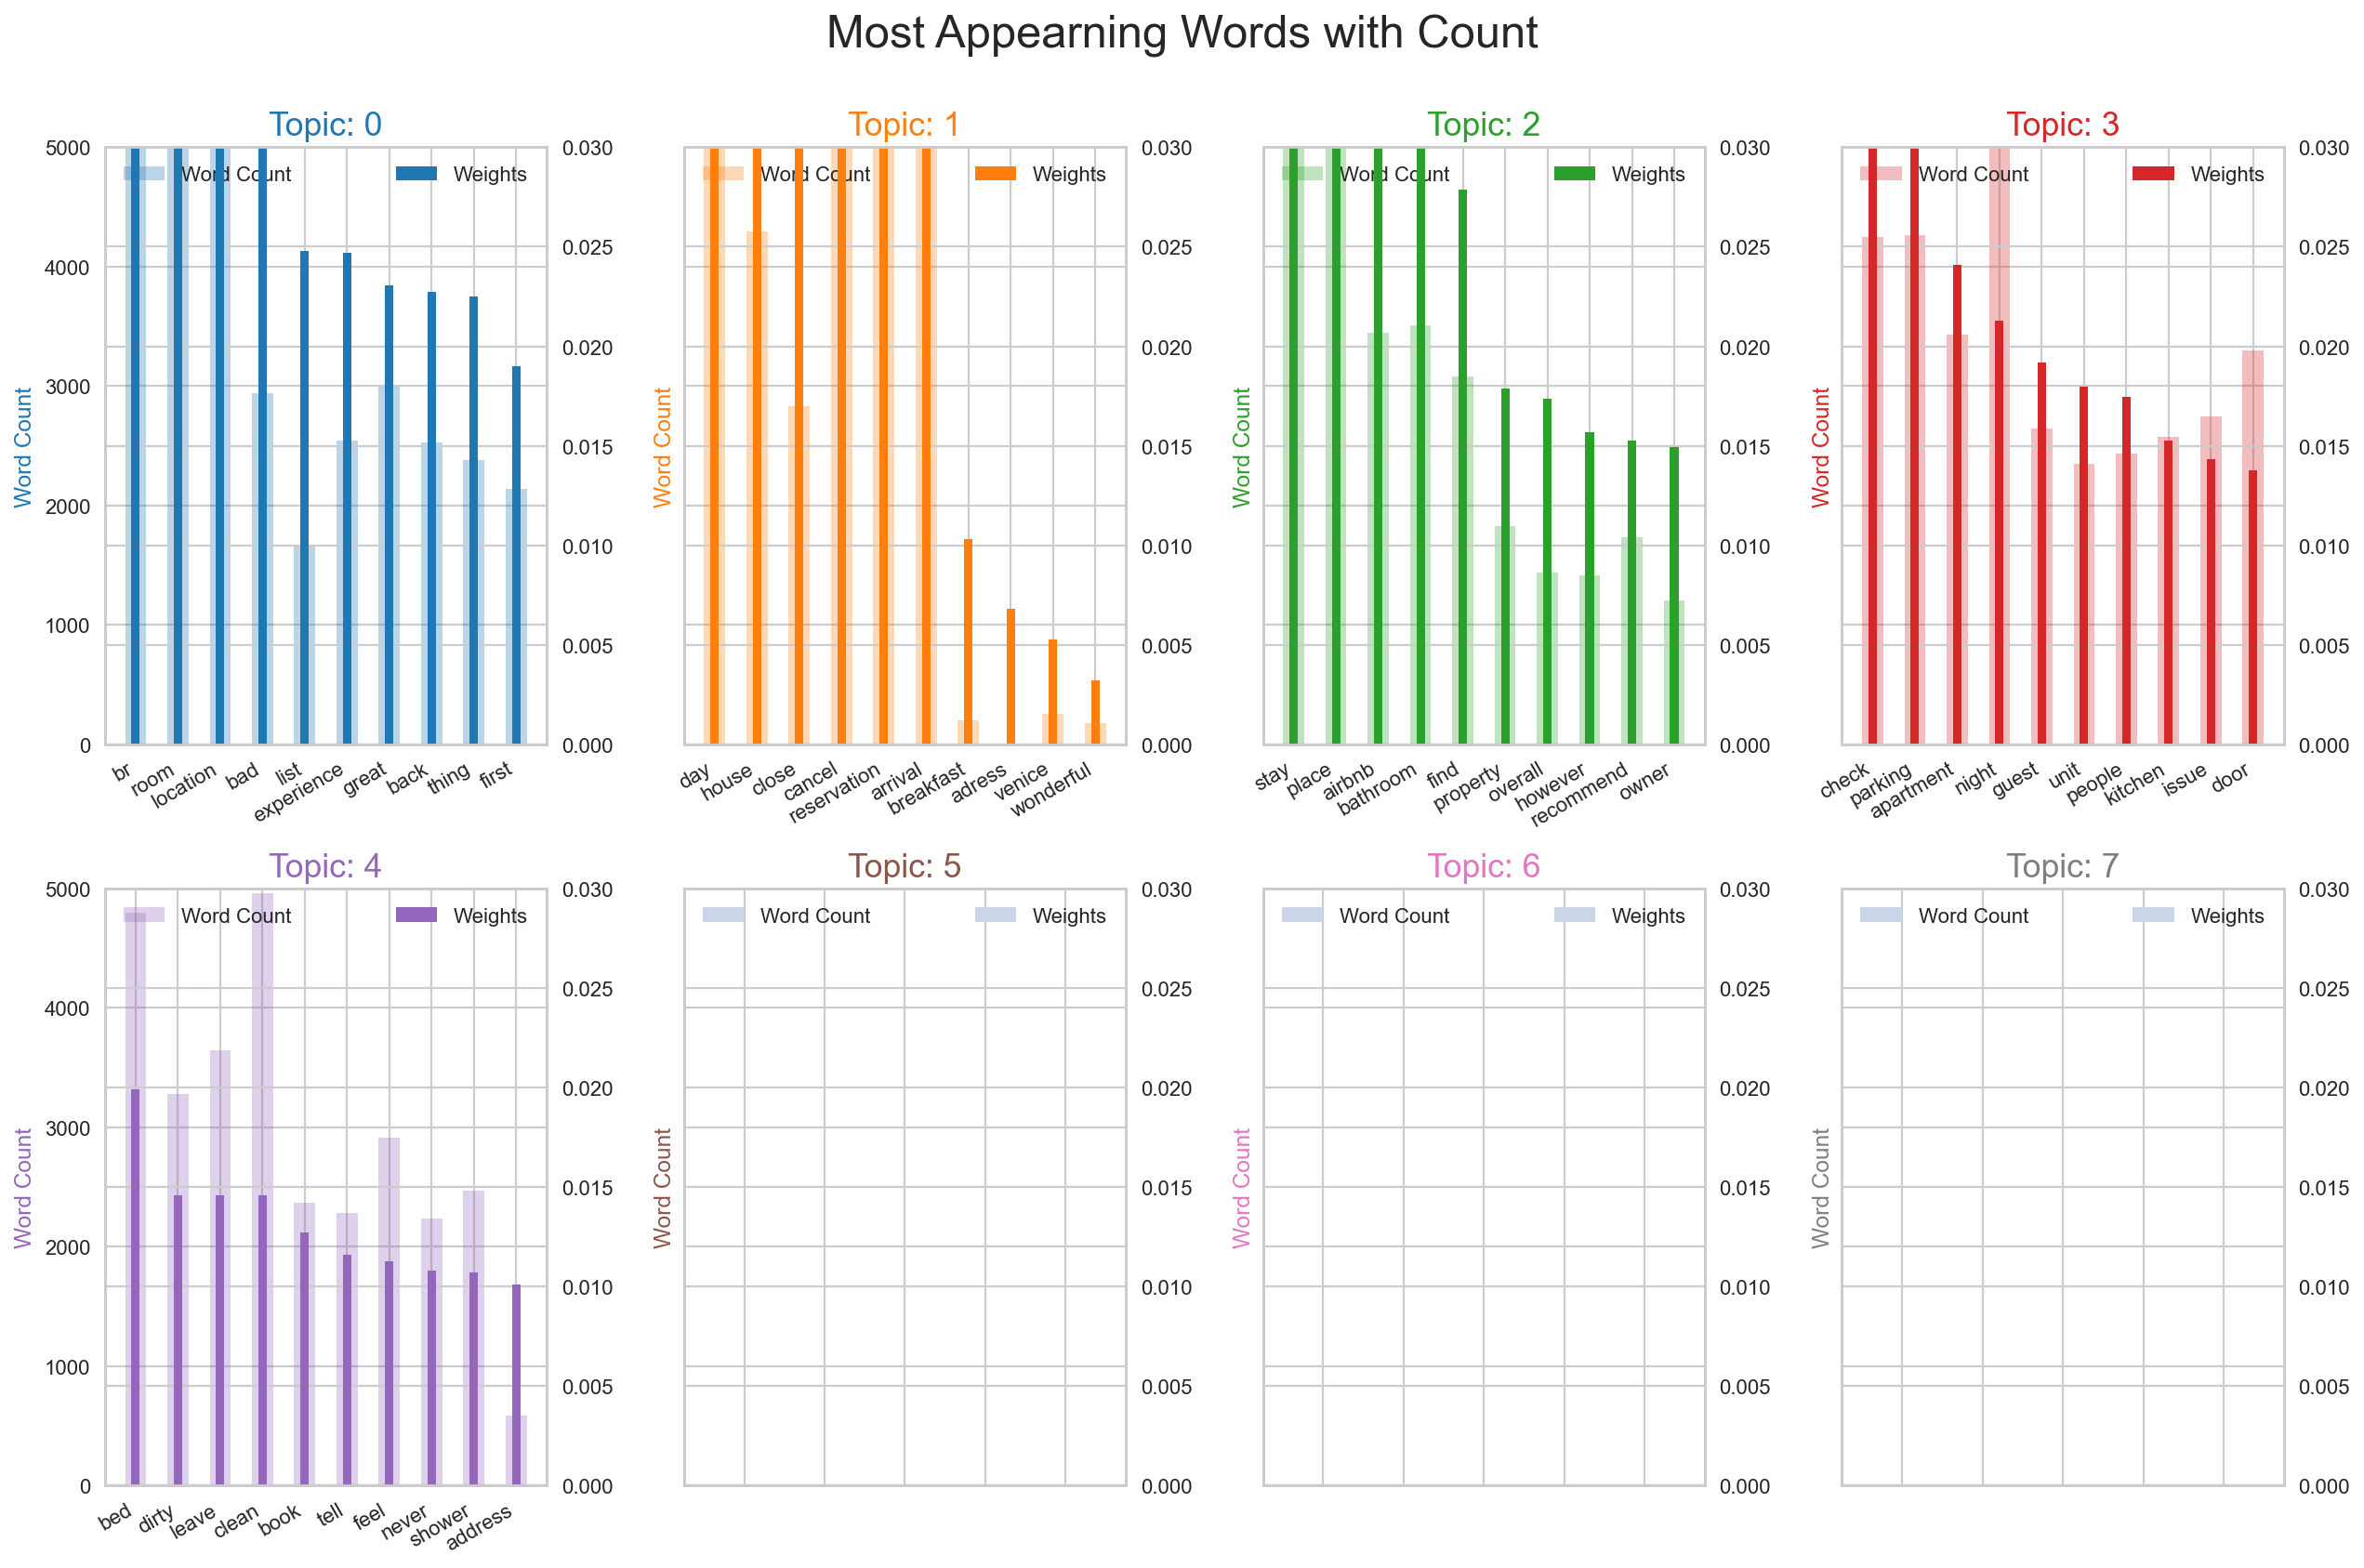

In [66]:
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    
    ax_twin.bar(x='word', height="most_appear", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    
    ax.set_xticklabels(df_f.loc[df_f.topic_n==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Most Appearning Words with Count', fontsize=22, y=1.05)   

plt.show()

## Words by Topic WordCloud

In [67]:

colors2 = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

topic_clouds = WordCloud(stopwords=stop_words,background_color='white', width=2500,height=1800, max_words=25, colormap='tab10',
                  color_func=lambda *args, **kwargs: colors2[i],prefer_horizontal=1.0)


IndexError: list index out of range

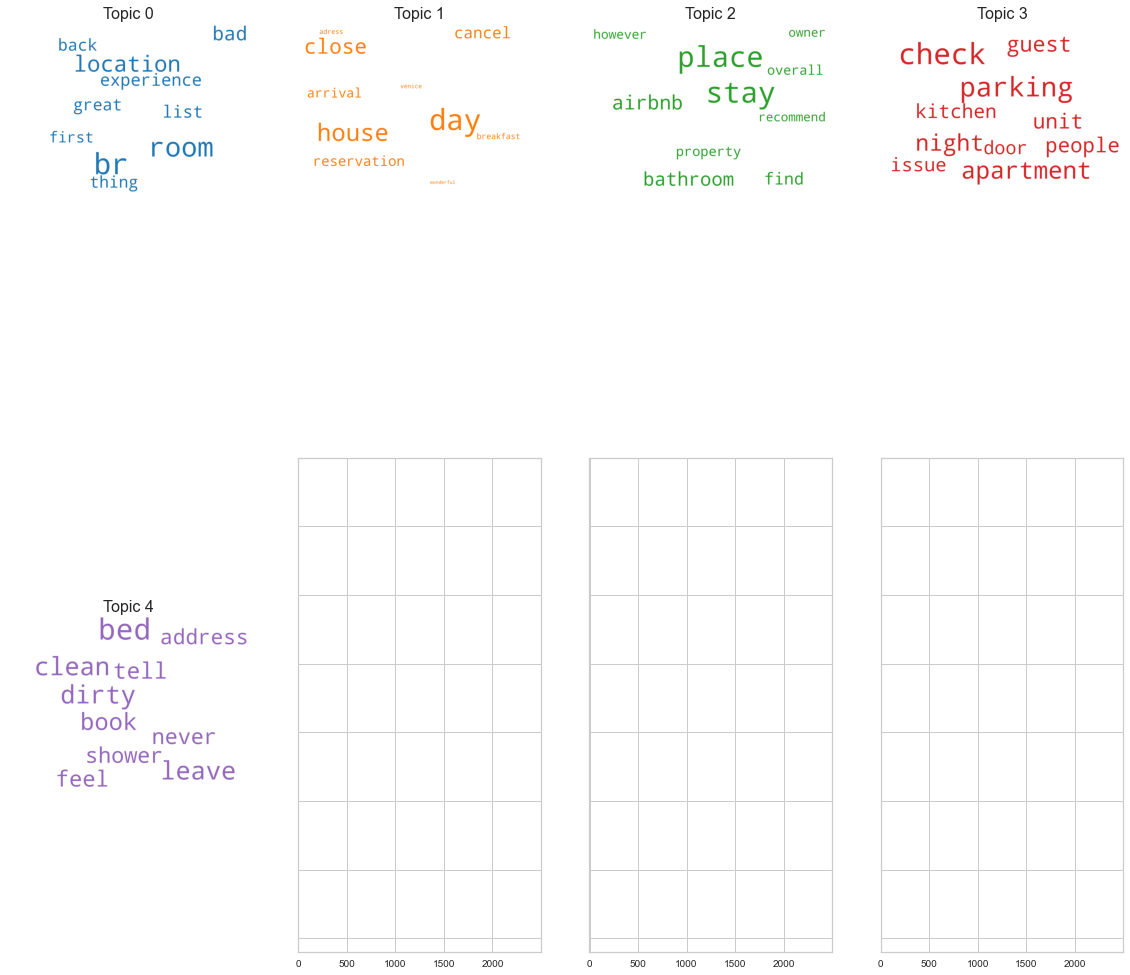

In [68]:
fig, axes = plt.subplots(2, 4, figsize=(20,20), sharex=True, sharey=True)
 

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    
    topic_words = dict(topics[i][1])
    topic_clouds.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(topic_clouds)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##  NMF run using 5 topics

In [69]:

nmf5 = NMF(n_components=5)

nmf5.fit(docs)

NMF(n_components=5)

In [70]:
topic_matrix = nmf5.transform(docs)

In [71]:
topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df['comments'] = df['comments']
topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,comments
0,0.000000,0.015285,0.000000,0.014628,0.000000,Top notch spot to stay within walking distance...
1,0.175557,0.020066,0.029669,0.000000,0.003768,"very unreliable host, <br/><br/>Wasn't helpfu..."
2,0.000399,0.013689,0.000000,0.004630,0.001049,Unit was hot. AC wasn't great.
3,0.000000,0.000000,0.195051,0.000000,0.000000,The host canceled this reservation 88 days bef...
4,0.000000,0.000534,0.000000,0.092897,0.000000,Wonderfull place to stay in LA near Venice Bea...


In [72]:
word_topic_matrix_df = pd.DataFrame(nmf5.components_, columns=features).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4
00,0.001006,0.160756,0.000000,0.000000,0.016797
000,0.001762,0.033207,0.004042,0.000000,0.013496
0000am,0.000000,0.000309,0.000000,0.000000,0.000000
001,0.000000,0.000000,0.000024,0.000989,0.000000
00am,0.000000,0.012322,0.001141,0.000975,0.000000


## Read Samples from Topic 0 

In [73]:
for review in topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['comments'].values:
    print(review)
    print()

Please be aware!!<br/>Avoid Avoid Avoid this place <br/><br/>I want to share it with anyone who rents from this listing!!!<br/><br/>Warning:<br/>Avoid Avoid Avoid this place at any price  again & again <br/><br/>This place is a 1-Star level like motel almost as if it houses prostitutes, drug dealers , or some other  shady Adult Enterprises it  might run  as a Home Business.<br/><br/>Location:<br/>Is Horrific location is in unsafe & ugly area of Hacienda Heights.<br/><br/>Most are very poor & beaten up housing area with its  suddenly appearing out of the  blue a set of the neighborhood street filled  with a few larger sized homes- of a working, lower middle class level.<br/>And then that neighborhood suddenly ends right there too.<br/><br/>That was also odd due to all surrounding area that was so shady & poor looking .<br/><br/>Freeways nearby:<br/>Crazy & so many angry drivers on along this specific direction.<br/>Not sure why  but something was so distinctive about it.<br/>It’s  also 

## Read Samples from Topic 1 


In [74]:
for review in topic_matrix_df.sort_values(by='topic_1', ascending=False).head(5)['comments'].values:
    print(review)
    print()

Hongfei6:35 PM<br/>Hello, why the staff here said Airbnb has canceled my booking with Moe?<br/>Did you cancel?<br/>Do you have a new place for me to go?<br/>Message from Airbnb Support<br/>Airbnb Support6:37 PM<br/>Nobody cancelled the reservation, the reservation with Alex is still pending is that right?<br/>Message from Hongfei<br/>Hongfei6:38 PM<br/>No, the booking with Moe<br/>I am here, the staff said Airbnb has canceled my booking , I can show you the text they just sent me<br/>Message from Airbnb Support<br/>Airbnb Support7:00 PM<br/>We are just letting them know that we are going to process it after they confirmed the full refund, if you look at your reservations, it is still active.<br/>If you do end up staying though, we cannot processa full refund and you will end up paying for the night.<br/>Message from Hongfei<br/>Hongfei7:02 PM<br/>All I know is that I did not cancel!<br/>They cost me difficulty to book a new place now<br/>Message from Airbnb Support<br/>Airbnb Support7:

## Read Samples from Topic 2


In [75]:
for review in topic_matrix_df.sort_values(by='topic_2', ascending=False).head(5)['comments'].values:
    print(review)
    print()

First, I would like to say this host is money greedy. Second, I would like to say I would not recommend this reservation to anyone except for the location. Before the trip even started I wish I was able to cancel my reservation with this host. To start, when I first booked the reservation. I booked a reservation for 7 guest The next day a family member of mine wanted to tag along and join the trip. So, I informed the host that I was trying to make a change to the reservation and add a extra guest. She immediately replied and sent me a confirmation link to accept the reservation change. Now the reservation is set to 8 guest and Of course adding an extra guest was going make the reservation go up some more money. About 200$. No longer then 24 hours go past. I messaged her again asking to change the reservation back to 7 guest because of some personal problem an guest had come up.  Not only did the host take a few hours to reply about change the reservation back. But when the host replied

# Top 10 Words from Each Topic

In [76]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [77]:
display_topics(nmf, features, 10)


Topic  0
br, airbnb, host, house, room, stay, kitchen, did, unit, time

Topic  1
place, stay, house, room, host, airbnb, did, night, just, didn

Topic  2
host, reservation, arrival, canceled, automated, posting, days, day, airbnb, refund


In [78]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
br,22.715577,0.000000,0.000000,0.000000,0.000000
airbnb,0.358875,4.907782,0.000000,0.000000,0.000000
kitchen,0.316334,0.943262,0.000000,0.513208,1.109567
host,0.315158,5.061398,6.533036,0.000000,0.058982
pros,0.250631,0.000000,0.000000,0.009147,0.000000
cons,0.246568,0.000000,0.000000,0.018939,0.000000
unit,0.240156,1.765372,0.000000,0.000000,0.000000
dirty,0.238900,1.069481,0.000000,0.842384,1.443502
broken,0.235410,0.560527,0.000000,0.186616,0.570420
issues,0.223286,0.848601,0.000000,0.131782,0.251219


In [79]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
host,0.315158,5.061398,6.533036,0.000000,0.058982
room,0.109642,5.038533,0.000000,0.000000,0.461202
airbnb,0.358875,4.907782,0.000000,0.000000,0.000000
stay,0.103401,4.708289,0.000000,2.602454,0.429230
did,0.118987,3.529628,0.000000,0.075612,0.634764
night,0.110110,2.971320,0.000000,0.735302,0.383452
didn,0.039652,2.604668,0.000000,0.408575,0.755960
just,0.027665,2.581817,0.000000,0.934306,0.743917
time,0.192176,2.502493,0.000000,0.339168,0.637734
day,0.119460,2.461889,0.485293,0.143738,0.648852


In [80]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
host,0.315158,5.061398,6.533036,0.000000,0.058982
reservation,0.000000,0.000000,4.983622,0.000000,0.000000
arrival,0.000000,0.000000,4.916023,0.000000,0.000000
canceled,0.000000,0.000000,4.777902,0.000000,0.000000
automated,0.000000,0.000000,4.726078,0.000000,0.000000
posting,0.000000,0.000000,4.723483,0.000000,0.000000
days,0.090189,0.304595,4.612586,0.192592,0.083310
day,0.119460,2.461889,0.485293,0.143738,0.648852
10,0.082959,0.425147,0.118970,0.147001,0.180068
14,0.029391,0.013145,0.106878,0.000000,0.013303


In [81]:
def top_reviews(topic_matrix_df, topic, num_of_reviews):
    return (topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(num_of_reviews)['comments']
            .values)

def top_words(word_topic_matrix_df, topic, n_of_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_of_words))[topic]

In [82]:
for review in top_reviews(topic_matrix_df, 'topic_0', 5):
    print(review)
    print()

Please be aware!!<br/>Avoid Avoid Avoid this place <br/><br/>I want to share it with anyone who rents from this listing!!!<br/><br/>Warning:<br/>Avoid Avoid Avoid this place at any price  again & again <br/><br/>This place is a 1-Star level like motel almost as if it houses prostitutes, drug dealers , or some other  shady Adult Enterprises it  might run  as a Home Business.<br/><br/>Location:<br/>Is Horrific location is in unsafe & ugly area of Hacienda Heights.<br/><br/>Most are very poor & beaten up housing area with its  suddenly appearing out of the  blue a set of the neighborhood street filled  with a few larger sized homes- of a working, lower middle class level.<br/>And then that neighborhood suddenly ends right there too.<br/><br/>That was also odd due to all surrounding area that was so shady & poor looking .<br/><br/>Freeways nearby:<br/>Crazy & so many angry drivers on along this specific direction.<br/>Not sure why  but something was so distinctive about it.<br/>It’s  also 

In [83]:
top_words(word_topic_matrix_df, 'topic_0', 10)

br         22.715577
airbnb      0.358875
kitchen     0.316334
host        0.315158
pros        0.250631
cons        0.246568
unit        0.240156
dirty       0.238900
broken      0.235410
issues      0.223286
Name: topic_0, dtype: float64

In [84]:
for review in top_reviews(topic_matrix_df, 'topic_1', 5):
    print(review)
    print()

Hongfei6:35 PM<br/>Hello, why the staff here said Airbnb has canceled my booking with Moe?<br/>Did you cancel?<br/>Do you have a new place for me to go?<br/>Message from Airbnb Support<br/>Airbnb Support6:37 PM<br/>Nobody cancelled the reservation, the reservation with Alex is still pending is that right?<br/>Message from Hongfei<br/>Hongfei6:38 PM<br/>No, the booking with Moe<br/>I am here, the staff said Airbnb has canceled my booking , I can show you the text they just sent me<br/>Message from Airbnb Support<br/>Airbnb Support7:00 PM<br/>We are just letting them know that we are going to process it after they confirmed the full refund, if you look at your reservations, it is still active.<br/>If you do end up staying though, we cannot processa full refund and you will end up paying for the night.<br/>Message from Hongfei<br/>Hongfei7:02 PM<br/>All I know is that I did not cancel!<br/>They cost me difficulty to book a new place now<br/>Message from Airbnb Support<br/>Airbnb Support7:

In [85]:
top_words(word_topic_matrix_df, 'topic_1', 10)

host      5.061398
room      5.038533
airbnb    4.907782
stay      4.708289
did       3.529628
night     2.971320
didn      2.604668
just      2.581817
time      2.502493
day       2.461889
Name: topic_1, dtype: float64

In [86]:
for review in top_reviews(topic_matrix_df, 'topic_2', 5):
    print(review)
    print()

First, I would like to say this host is money greedy. Second, I would like to say I would not recommend this reservation to anyone except for the location. Before the trip even started I wish I was able to cancel my reservation with this host. To start, when I first booked the reservation. I booked a reservation for 7 guest The next day a family member of mine wanted to tag along and join the trip. So, I informed the host that I was trying to make a change to the reservation and add a extra guest. She immediately replied and sent me a confirmation link to accept the reservation change. Now the reservation is set to 8 guest and Of course adding an extra guest was going make the reservation go up some more money. About 200$. No longer then 24 hours go past. I messaged her again asking to change the reservation back to 7 guest because of some personal problem an guest had come up.  Not only did the host take a few hours to reply about change the reservation back. But when the host replied

In [87]:
top_words(word_topic_matrix_df, 'topic_2', 10)

host           6.533036
reservation    4.983622
arrival        4.916023
canceled       4.777902
automated      4.726078
posting        4.723483
days           4.612586
day            0.485293
10             0.118970
14             0.106878
Name: topic_2, dtype: float64

In [88]:
t1 = top_words(word_topic_matrix_df, 'topic_0', 100)
t1_10 = top_words(word_topic_matrix_df, 'topic_0', 10)

In [89]:
tl_dict = t1.to_dict()

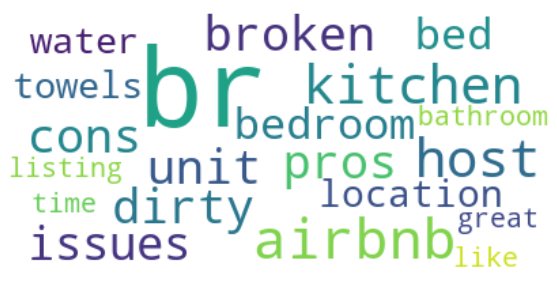

In [90]:
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(tl_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic1')
plt.show()


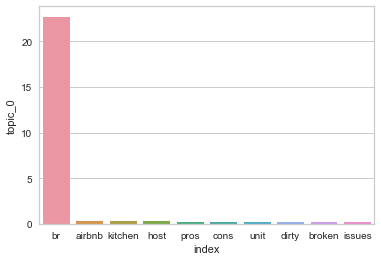

In [91]:
l_df = t1_10.to_frame()
l_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_0', data=l_df);

In [92]:
second_top = top_words(word_topic_matrix_df, 'topic_1', 100)
t2_10 = top_words(word_topic_matrix_df, 'topic_1', 10)

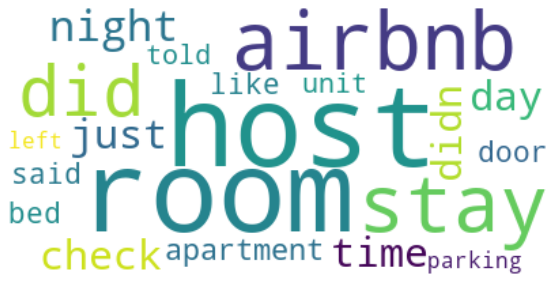

In [93]:
second_top_dict = second_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(second_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic2')
plt.show()


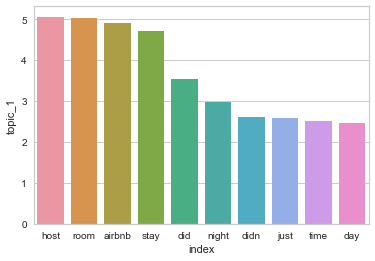

In [94]:
t2_df = t2_10.to_frame()
t2_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_1', data=t2_df);

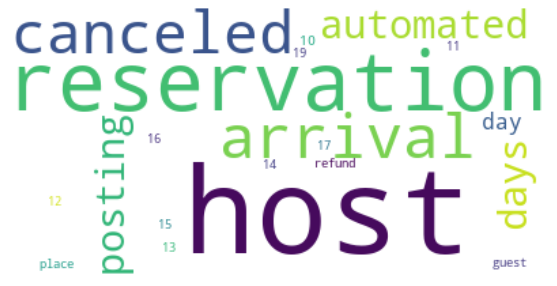

In [95]:
third_top = top_words(word_topic_matrix_df, 'topic_2', 100)
t3_10 = top_words(word_topic_matrix_df, 'topic_2', 10)


third_top_dict = third_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(third_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic3')
plt.show()

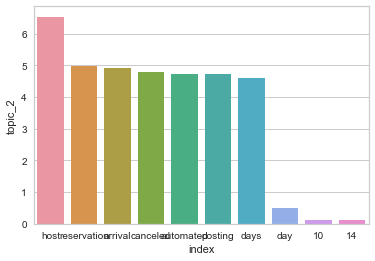

In [96]:
t3_df = t3_10.to_frame()
t3_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_2', data=t3_df);